# Build movie recommendation system
- This project implements a movie recommendation system using both content-based and collaborative filtering techniques, providing personalized movie recommendations based on user preferences.

<img src="https://raw.githubusercontent.com/jalajthanaki/Movie_recommendation_engine/master/img/3_1.gif" 
align="middle" alt="Figure 3_1" data-canonical-src="" style="width:40%;height:40%">

# Project Outline

## 1. Import Dependencies
- Import necessary libraries such as pandas, numpy, and scikit-learn for data manipulation and modeling.

## 2. Load Dataset
- Load the movie dataset containing information about movies, users, and ratings.

## 3. Data Preprocessing
- Explore the dataset to understand its structure, features, and distributions.
- Check for missing values and outliers that may need to be addressed during data preprocessing.

## 4. Exploratory Data Analysis
- Perform any necessary data cleaning and transformation steps to prepare the dataset for modeling.

## 5. Build Recommendation System
- Build different types of recommendation systems:

   ### 5.1 Simple Recommendation System
   - Implement a basic recommendation system (e.g., top N most popular movies) to establish a baseline for comparison.

   ### 5.2 Content-Based Recommendation System
   - Implement a content-based recommendation system that suggests movies similar to those a user has liked in the past, based on movie features (e.g., genres, directors, actors). 

   ### 5.3 Collaborative Filtering (CF) Recommendation System
   - Implement user-based or item-based collaborative filtering to recommend movies based on the preferences of similar users or items.

   ### 5.4 Hybrid Recommendation System
   - Combine the content-based and CF recommendation systems to create a hybrid model that provides more accurate and diverse recommendations.

## 6. Evaluate the performance
- Evaluation of each recommendation system using metrics such as accuracy, precision, recall, and F1-score.







## 1. Import libraries

In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset, SVD




import warnings; warnings.simplefilter('ignore')

## 2. Load dataset

We have MovieLens datasets.

**The Full Dataset:** Consists of 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users. Includes tag genome data with 12 million relevance scores across 1,100 tags.

**The Small Dataset:** Comprises of 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users.

We will build our Simple Recommender using movies from the Full Dataset 

In [2]:
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')
links_small = pd.read_csv('links_small.csv')
movies = pd.read_csv('movies_metadata.csv')
ratings = pd.read_csv('ratings_small.csv')

## 3. Data Preprocessing

#### Credits dataframe

In [3]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [4]:
credits.columns

Index(['cast', 'crew', 'id'], dtype='object')

In [5]:
credits.isnull().sum()

cast    0
crew    0
id      0
dtype: int64

* **cast:** Information about casting. Name of actor, gender and it's character name in movie
* **crew:** Information about crew members. Like who directed the movie, editor of the movie and so on. 
* **id:** It's movie ID given by TMDb

In [6]:
credits.shape

(45476, 3)

In [7]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


#### Keywords dataframe

In [8]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [9]:
keywords.columns

Index(['id', 'keywords'], dtype='object')

* **id:** It's movie ID given by TMDb
* **Keywords:** Tags/keywords for the movie. It list of tags/keywords 

In [10]:
keywords.shape

(46419, 2)

In [11]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


#### Link dataframe

In [12]:
links_small.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [13]:
links_small.columns

Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')

In [14]:
links_small.isnull().sum()

movieId     0
imdbId      0
tmdbId     13
dtype: int64

In [15]:
links_small.dropna(inplace=True)

In [16]:
links_small.isnull().sum()

movieId    0
imdbId     0
tmdbId     0
dtype: int64

* **movieId:** It's serial number for movie
* **imdbId:** Movie id given on IMDb platform
* **tmdbId**: Movie id given on TMDb platform

In [17]:
links_small.shape

(9112, 3)

In [18]:
links_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9112 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9112 non-null   int64  
 1   imdbId   9112 non-null   int64  
 2   tmdbId   9112 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 284.8 KB


#### Metadata dataframe

In [19]:
movies.iloc[0:3].transpose()

,0,1,2
adult,False,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"{'id': 119050, 'name': 'Grumpy Old Men Collect..."
budget,30000000,65000000,0
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
homepage,http://toystory.disney.com/toy-story,NaN,NaN
id,862,8844,15602
imdb_id,tt0114709,tt0113497,tt0113228
original_language,en,en,en
original_title,Toy Story,Jumanji,Grumpier Old Men
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,A family wedding reignites the ancient feud be...


In [20]:
movies.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

**Features**

* **adult:** Indicates if the movie is X-Rated or Adult.
* **belongs_to_collection:** A stringified dictionary that gives information on the movie series the particular film belongs to.
* **budget:** The budget of the movie in dollars.
* **genres:** A stringified list of dictionaries that list out all the genres associated with the movie.
* **homepage:** The Official Homepage of the move.
* **id:** The ID of the movie.
* **imdb_id:** The IMDB ID of the movie.
* **original_language:** The language in which the movie was originally shot in.
* **original_title:** The original title of the movie.
* **overview:** A brief blurb of the movie.
* **popularity:** The Popularity Score assigned by TMDB.
* **poster_path:** The URL of the poster image.
* **production_companies:** A stringified list of production companies involved with the making of the movie.
* **production_countries:** A stringified list of countries where the movie was shot/produced in.
* **release_date:** Theatrical Release Date of the movie.
* **revenue:** The total revenue of the movie in dollars.
* **runtime:** The runtime of the movie in minutes.
* **spoken_languages:** A stringified list of spoken languages in the film.
* **status:** The status of the movie (Released, To Be Released, Announced, etc.)
* **tagline:** The tagline of the movie.
* **title:** The Official Title of the movie.
* **video:** Indicates if there is a video present of the movie with TMDB.
* **vote_average:** The average rating of the movie.
* **vote_count:** The number of votes by users, as counted by TMDB.

In [21]:

movies.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [22]:
movies.shape

(45466, 24)

In [23]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [24]:
movies.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [25]:
## Pre-processing step

def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan


In [26]:
movies['id'] = movies['id'].apply(convert_int)
movies[movies['id'].isnull()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",NaN,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
movies = movies.drop([19730, 29503, 35587])

In [28]:
movies['id'] = movies['id'].astype('int')

In [29]:
movies.fillna({'revenue': 0, 'runtime': 0, 'vote_average': 0, 'vote_count': 0}, inplace=True)


In [30]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movies['id'] = movies['id'].astype('int')

In [31]:
movies.iloc[0:3].transpose()

,0,1,2
adult,False,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"{'id': 119050, 'name': 'Grumpy Old Men Collect..."
budget,30000000,65000000,0
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
homepage,http://toystory.disney.com/toy-story,NaN,NaN
id,862,8844,15602
imdb_id,tt0114709,tt0113497,tt0113228
original_language,en,en,en
original_title,Toy Story,Jumanji,Grumpier Old Men
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,A family wedding reignites the ancient feud be...


#### Ratings dataframe

In [32]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [33]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

* **userId:** It is id for User
* **movieId:** It is TMDb movie id.
* **rating:** Rating given for the particular movie by specific user
* **timestamp:** Time stamp when rating has been given by user

In [34]:
ratings.shape

(100004, 4)

In [35]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [36]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

## Data Preprocessing

In [37]:
movies.iloc[0].genres

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

In [38]:
def convert(obj):
    l=[]
    for i in ast.literal_eval(obj):
        l.append(i['name'])
    return l
        

In [39]:
keywords['keywords'] = keywords['keywords'].apply(convert)

In [40]:
keywords.head()

,id,keywords
0,862,"[jealousy, toy, boy, friendship, friends, riva..."
1,8844,"[board game, disappearance, based on children'..."
2,15602,"[fishing, best friend, duringcreditsstinger, o..."
3,31357,"[based on novel, interracial relationship, sin..."
4,11862,"[baby, midlife crisis, confidence, aging, daug..."


In [41]:
import ast
import numpy as np

def convert(obj):
    if pd.isna(obj):
        return []
    l = []
    for i in ast.literal_eval(obj):
        l.append(i['name'])
    return l

movies['production_companies'] = movies['production_companies'].apply(convert)


In [42]:
def convert(obj):
    l=[]
    counter=0
    for i in ast.literal_eval(obj):
        if counter != 3:
            l.append(i['name'])
            counter+=1
        else:
            break
    return l
        

In [43]:
movies['genres'] = movies['genres'].apply(convert)

**1. Crew:** From the crew, we will only pick the director as our feature since the others don't contribute that much to the feel of the movie.

**2. Cast:** Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 3 actors that appear in the credits list.

In [44]:
credits['cast'] = credits['cast'].apply(convert)

In [45]:
def fetch_director(obj):
    l=[]
    for i in ast.literal_eval(obj):
        if i['job'] == 'Director':
            l.append(i['name'])
            break
    return l

In [46]:
credits['crew'] = credits['crew'].apply(fetch_director)

In [47]:
credits.head()

,cast,crew,id
0,"[Tom Hanks, Tim Allen, Don Rickles]",[John Lasseter],862
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",[Joe Johnston],8844
2,"[Walter Matthau, Jack Lemmon, Ann-Margret]",[Howard Deutch],15602
3,"[Whitney Houston, Angela Bassett, Loretta Devine]",[Forest Whitaker],31357
4,"[Steve Martin, Diane Keaton, Martin Short]",[Charles Shyer],11862


In [48]:
movies['overview'] = movies['overview'].fillna('').apply(lambda x: x.split())


In [49]:
movies['tagline'] = movies['tagline'].fillna('').apply(lambda x: x.split())


In [50]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"[Led, by, Woody,, Andy's, toys, live, happily,...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,[],Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,"[When, siblings, Judy, and, Peter, discover, a...",...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"[Roll, the, dice, and, unleash, the, excitement!]",Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,"[A, family, wedding, reignites, the, ancient, ...",...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[Still, Yelling., Still, Fighting., Still, Rea...",Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"[Cheated, on,, mistreated, and, stepped, on,, ...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[Friends, are, the, people, who, let, you, be,...",Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,"[Just, when, George, Banks, has, recovered, fr...",...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[Just, When, His, World, Is, Back, To, Normal....",Father of the Bride Part II,False,5.7,173.0


In [51]:
movies.shape

(45463, 24)

## 4. Exploratory Data Analysis

1. What is the distribution of movie genres in the dataset?
2. How many unique users and movies are present in the ratings dataset?
3. How has the popularity of movies changed over the years?
4. What is the distribution of movie ratings (vote_average) in the dataset?
5. Are there any correlations between movie budget, revenue, and ratings?
6. Are there any trends in movie release dates over the years?
7. What is the distribution of user ratings (or votes) per movie?
8. What are the top keywords used to describe movies in the keywords dataset?
9. What are the top production companies in the dataset?







### 1. Distribution of movie genres

<Axes: title={'center': 'Distribution of Movie Genres'}>

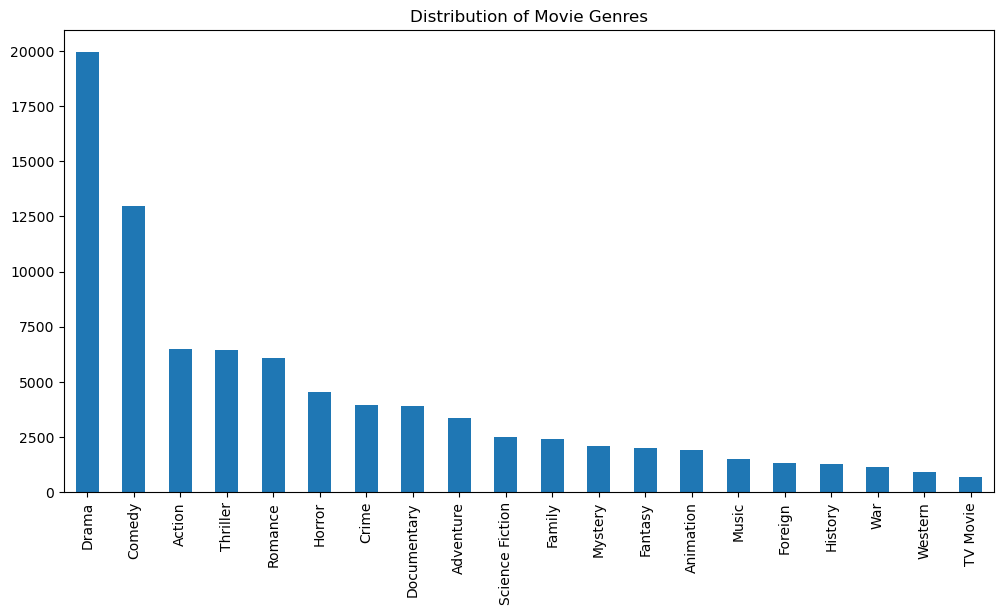

In [52]:
genres_list = movies['genres'].explode()

# Count the occurrences of each genre
genre_counts = genres_list.value_counts()

# Plot the distribution of movie genres
genre_counts.plot(kind='bar', figsize=(12, 6), title='Distribution of Movie Genres')

The most common genres in movies are drama, followed by comedy, action, and thriller.

## 2. Unique number of users and movies

In [53]:
unique_users = ratings['userId'].nunique()
unique_movies = ratings['movieId'].nunique()

print(f"Number of unique users: {unique_users}")
print(f"Number of unique movies: {unique_movies}")

Number of unique users: 671
Number of unique movies: 9066


## 3. Average Popularity Of Movies Over Years

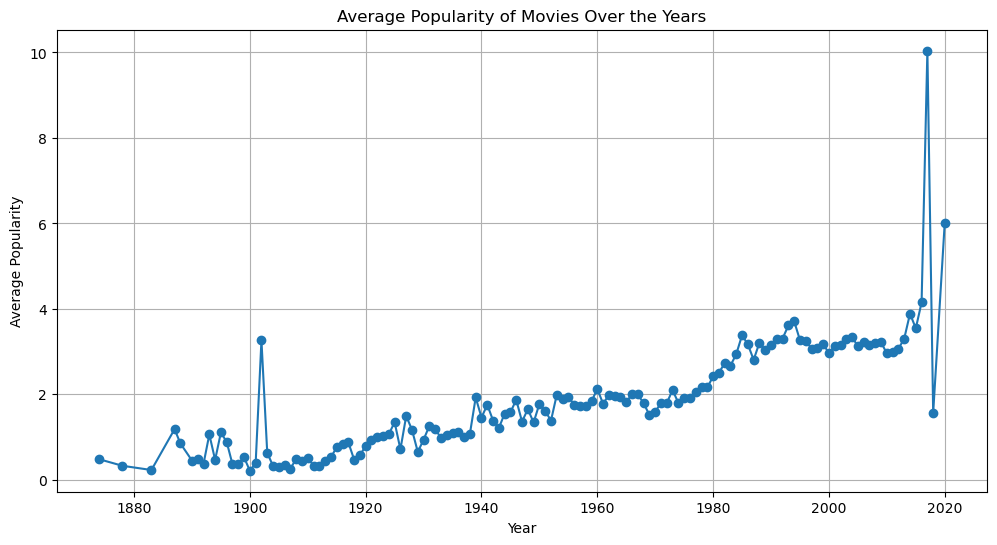

In [54]:
movies['popularity'] = pd.to_numeric(movies['popularity'], errors='coerce')
mean_popularity = movies['popularity'].mean()
movies['popularity'].fillna(mean_popularity, inplace=True)

movies['release_date'] = pd.to_datetime(movies['release_date'])

# Extract year from 'release_date'
movies['release_year'] = movies['release_date'].dt.year

# Group by 'release_year' and calculate the average popularity for each year
popularity_by_year = movies.groupby('release_year')['popularity'].mean()

# Plot the popularity trend over the years
plt.figure(figsize=(12, 6))
plt.plot(popularity_by_year.index, popularity_by_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Average Popularity')
plt.title('Average Popularity of Movies Over the Years')
plt.grid(True)
plt.show()

### 4. Distribution of movie ratings

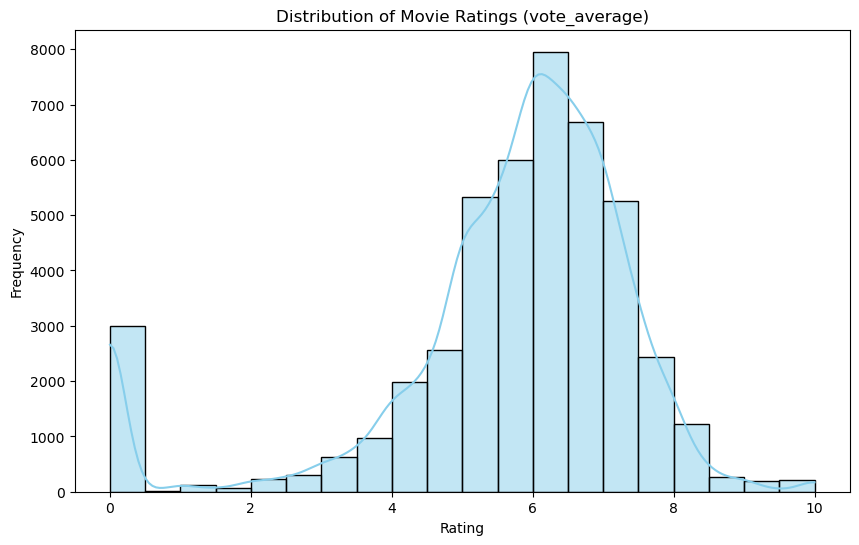

In [55]:
plt.figure(figsize=(10, 6))
sns.histplot(data=movies, x='vote_average', bins=20, kde=True, color='skyblue')
plt.title('Distribution of Movie Ratings (vote_average)')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


### 5. Correlations between movie budget, revenue, and ratings

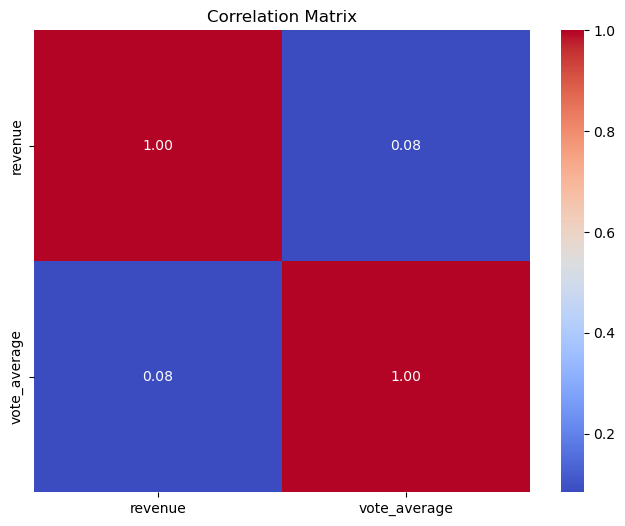

In [56]:
# Selecting relevant columns
numerical_columns = ['budget', 'revenue', 'vote_average']
numerical_data = movies[numerical_columns]

# Calculating the correlation matrix
correlation_matrix = numerical_data.corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


### 6. Trends in movie release dates over the years

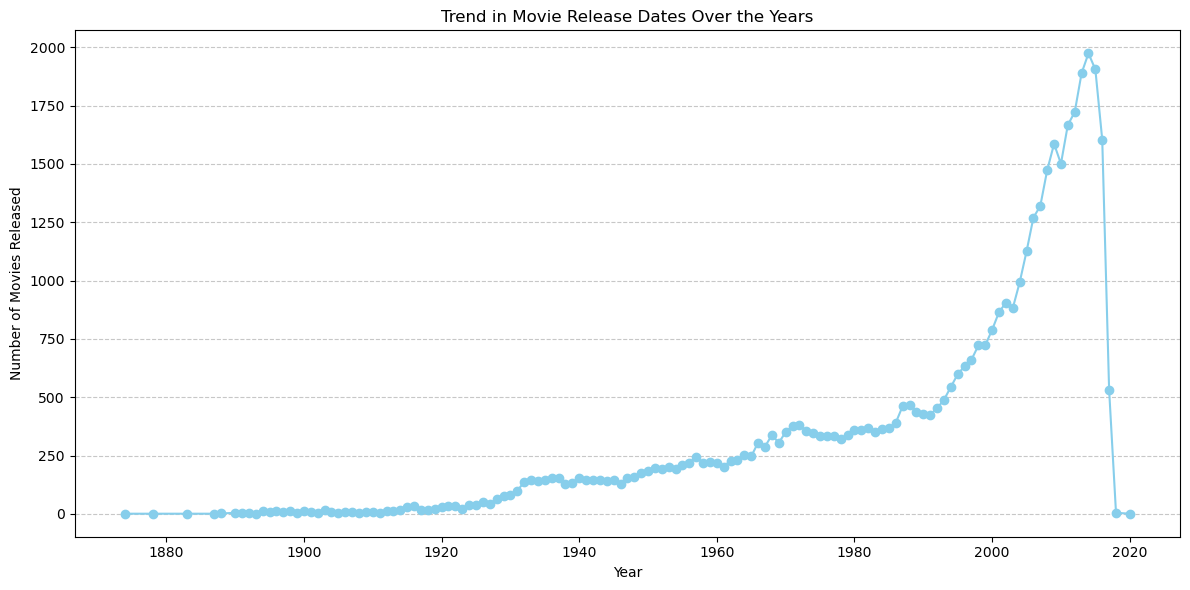

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have loaded the dataset into 'movies'

# Extract the year from the release_date column
movies['release_year'] = pd.to_datetime(movies['release_date']).dt.year

# Group the movies by release year to get the count of movies released each year
movies_per_year = movies.groupby('release_year').size()

# Visualize the trend in movie release dates over the years
plt.figure(figsize=(12, 6))
movies_per_year.plot(kind='line', marker='o', color='skyblue')
plt.title('Trend in Movie Release Dates Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 7. Distribution of user ratings (or votes) per movie

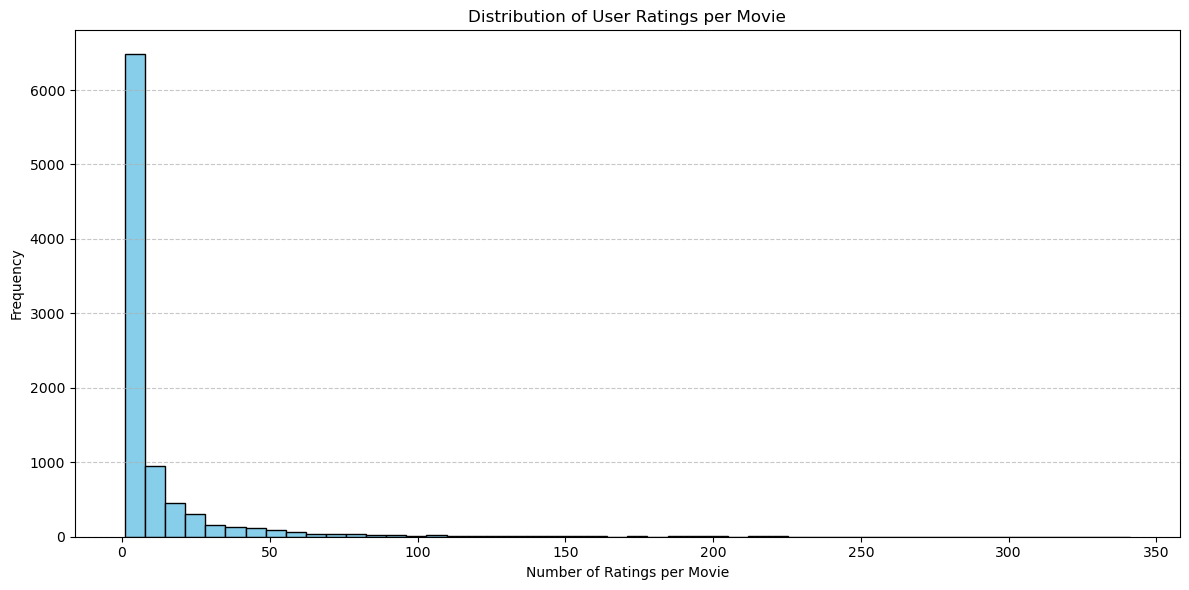

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have loaded the dataset into 'ratings_df'

# Group the ratings dataset by movieId to get the count of ratings for each movie
ratings_per_movie = ratings.groupby('movieId').size()

# Visualize the distribution of ratings per movie
plt.figure(figsize=(12, 6))
plt.hist(ratings_per_movie, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of User Ratings per Movie')
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 8.Top Keywords

In [59]:
keywords_list = keywords['keywords'].explode()

# Count the occurrences of each keyword
keyword_counts = keywords_list.value_counts()

# Print the top keywords
print("Top keywords:")
print(keyword_counts.head(10))

Top keywords:
woman director      3115
independent film    1930
murder              1308
based on novel       835
musical              734
sex                  685
violence             651
nudity               636
biography            629
revenge              626
Name: keywords, dtype: int64


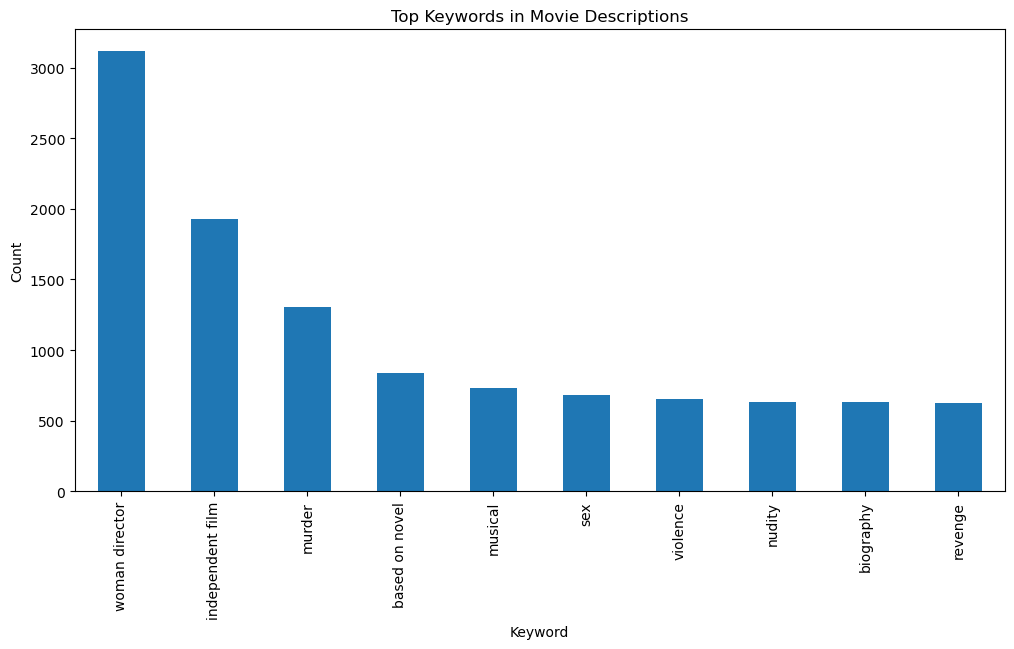

In [60]:
plt.figure(figsize=(12, 6))
keyword_counts.head(10).plot(kind='bar', title='Top Keywords in Movie Descriptions')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.show()

## 9.Top Production Companies

In [61]:
production_companies_list = movies['production_companies'].explode()

# Count the occurrences of each production company
production_company_counts = production_companies_list.value_counts()

# Print the top production companies
print("Top production companies:")
print(production_company_counts.head(10))

Top production companies:
Warner Bros.                              1250
Metro-Goldwyn-Mayer (MGM)                 1076
Paramount Pictures                        1003
Twentieth Century Fox Film Corporation     836
Universal Pictures                         830
Columbia Pictures Corporation              448
Canal+                                     438
Columbia Pictures                          431
RKO Radio Pictures                         290
United Artists                             279
Name: production_companies, dtype: int64


Text(0, 0.5, 'Count')

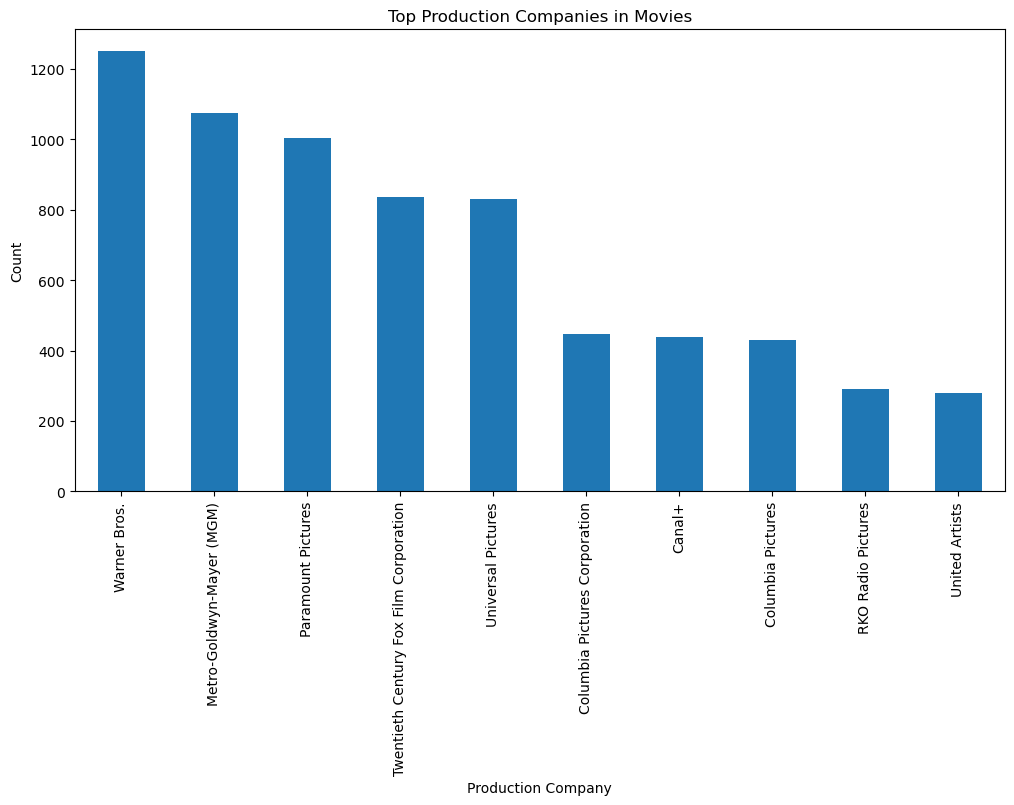

In [62]:

# Plot the top 10 production companies
plt.figure(figsize=(12, 6))
production_company_counts.head(10).plot(kind='bar', title='Top Production Companies in Movies')
plt.xlabel('Production Company')
plt.ylabel('Count')

In [63]:
movies_df_exploded = movies.explode('production_companies')

# Group by production company and calculate the average rating
production_company_ratings = movies_df_exploded.groupby('production_companies')['vote_average'].mean()

# Print the top production companies according to ratings
print("Top production companies according to ratings:")
print(production_company_ratings.sort_values(ascending=False).head(10))

Top production companies according to ratings:
production_companies
Vanguardia Films                 10.0
Roberto Me Dejó Films            10.0
One Small Instrument Pictures    10.0
Marquise                         10.0
Chase Productions                10.0
INCAA                            10.0
Rhino Media                      10.0
AMV Production                   10.0
Wood-Thomas Pictures             10.0
Les Films Fauves                 10.0
Name: vote_average, dtype: float64


## 6. Build recommendation system

### 6.1. Simple recommendation system

**Approach: **

* The Simple Recommender offers __generalized recommendations__ to every user __based on movie popularity and (sometimes) genre__. 

* The __basic idea__ behind this recommender is that __movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience.__ 

* This model __does not give personalized recommendations__ based on the user.



**What we are actually doing: **

* The implementation of this model is extremely trivial. 
* All we have to do is __sort our movies based on ratings and popularity__ and display the top movies of our list. 
* As an added step, we can __pass in a genre argument to get the top movies of a particular genre.__

I will build our overall Top 250 Chart and will define a function to build charts for a particular genre. Let's begin!

* I use the TMDB Ratings to come up with our Top Movies Chart. 
* I will use IMDB's weighted rating formula to construct my chart.
* Mathematically, it is represented as follows:



$\large Weighted\; Rating (WR) = (\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$
```
where,
    v is the number of votes for the movie
    m is the minimum votes required to be listed in the chart
    R is the average rating of the movie
    C is the mean vote across the whole report
```

In [64]:
# this is V
vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')

# this is R
vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')

# this is C
C = vote_averages.mean()
C

5.244550513604469

* The next step, we need to determine an appropriate value for `m`, the minimum votes required to be listed in the chart. 

* We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.



In [65]:
m = vote_counts.quantile(0.95)
m

433.90000000000146

In [66]:
# Pre-processing step for getting year from date by splliting it using '-'

movies['year'] = pd.to_datetime(movies['release_date'], errors='coerce').apply(
    lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [67]:
qualified = movies[(movies['vote_count'] >= m) & 
               (movies['vote_count'].notnull()) & 
               (movies['vote_average'].notnull())][['title', 
                                                'year', 
                                                'vote_count', 
                                                'vote_average', 
                                                'popularity', 
                                                'genres']]

qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

* Therefore, to qualify to be considered for the chart, a movie has to have at least __434 votes__ on TMDB. 
* We also see that the __average rating__ for __a movie on TMDB__ is __5.244 on a scale of 10__. 
* Here, only __2274 movies__ are qualify to be on our chart.

In [68]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [69]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [70]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

**Top Movies**

In [71]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction]",7.917596
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime]",7.905881
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897117
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881764
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871799
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868673
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864012
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861940
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860669
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851938


* We see that three Christopher Nolan Films, __Inception__, __The Dark Knight__ and __Interstellar__ occur at the very top of our chart. 
* The chart also indicates a strong bias of TMDB Users towards particular genres and directors.

* Let us now construct our __function that builds charts for particular genres.__

* For this, we __relax__ our __default conditions to the 85th percentile instead of 95.__

In [72]:
s = movies.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = movies.drop('genres', axis=1).join(s)
gen_md.head(3).transpose()

,0,0,0
adult,False,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...","{'id': 10194, 'name': 'Toy Story Collection', ...","{'id': 10194, 'name': 'Toy Story Collection', ..."
budget,30000000,30000000,30000000
homepage,http://toystory.disney.com/toy-story,http://toystory.disney.com/toy-story,http://toystory.disney.com/toy-story
id,862,862,862
imdb_id,tt0114709,tt0114709,tt0114709
original_language,en,en,en
original_title,Toy Story,Toy Story,Toy Story
overview,"[Led, by, Woody,, Andy's, toys, live, happily,...","[Led, by, Woody,, Andy's, toys, live, happily,...","[Led, by, Woody,, Andy's, toys, live, happily,..."
popularity,21.946943,21.946943,21.946943


In [73]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & 
                   (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: 
                        (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C),
                        axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

Let us see our method in action by displaying the __Top 15 Romance Movies__ (Romance almost didn't feature at all in our Generic Top Chart despite being one of the most popular movie genres).


**Top 15 Romantic Movies**

In [74]:
build_chart('Romance').head(5)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.593391
351,Forrest Gump,1994,8147,8,48.307194,7.973403
876,Vertigo,1958,1162,8,18.208220,7.824299
40251,Your Name.,2016,1030,8,34.461252,7.803480
883,Some Like It Hot,1959,835,8,11.845107,7.761781


In [75]:
build_chart('Action').head(5)

,title,year,vote_count,vote_average,popularity,wr
15480,Inception,2010,14075,8,29.108149,7.955030
12481,The Dark Knight,2008,12269,8,123.167259,7.948530
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,7.929470
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,7.923913
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,7.918255


In [76]:
build_chart('Fantasy').head(5)

,title,year,vote_count,vote_average,popularity,wr
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,7.898973
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,7.891130
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,7.883163
3030,The Green Mile,1999,4166,8,19.966780,7.793310
5481,Spirited Away,2001,3968,8,41.048867,7.783838


### 6.2 Content based recommendation system

In [77]:
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [78]:
movies = movies[movies['id'].isin(links_small)]
movies.shape


(9099, 26)

We have __9099 movies__ available in our small movies metadata dataset which is 5 times smaller than our original dataset of 45000 movies.

###  Content based recommendation system : Using movie overview and taglines

* Let us first try to build a recommender using movie overviews and taglines. 
* We do not have a quantitative metric to judge our machine's performance so this will have to be done 
  qualitatively.

In [79]:

movies['description'] = movies['overview'] + movies['tagline']


In [80]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_year,year,description
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"[Led, by, Woody,, Andy's, toys, live, happily,...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,[],Toy Story,False,7.7,5415.0,1995.0,1995,"[Led, by, Woody,, Andy's, toys, live, happily,..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,"[When, siblings, Judy, and, Peter, discover, a...",...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"[Roll, the, dice, and, unleash, the, excitement!]",Jumanji,False,6.9,2413.0,1995.0,1995,"[When, siblings, Judy, and, Peter, discover, a..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,"[A, family, wedding, reignites, the, ancient, ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[Still, Yelling., Still, Fighting., Still, Rea...",Grumpier Old Men,False,6.5,92.0,1995.0,1995,"[A, family, wedding, reignites, the, ancient, ..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"[Cheated, on,, mistreated, and, stepped, on,, ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[Friends, are, the, people, who, let, you, be,...",Waiting to Exhale,False,6.1,34.0,1995.0,1995,"[Cheated, on,, mistreated, and, stepped, on,, ..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,"[Just, when, George, Banks, has, recovered, fr...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[Just, When, His, World, Is, Back, To, Normal....",Father of the Bride Part II,False,5.7,173.0,1995.0,1995,"[Just, when, George, Banks, has, recovered, fr..."


In [81]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
movies['description'] = movies['description'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

tfidf_matrix = tf.fit_transform(movies['description'])

In [82]:
tfidf_matrix.shape

(9099, 267952)

* Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. 

* Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [83]:

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [84]:
cosine_sim[0]
#cosine_sim.shape

array([1.        , 0.00680491, 0.        , ..., 0.        , 0.00344926,
       0.        ])

* We now have a pairwise cosine similarity matrix for all the movies in our dataset. 
* The next step is to write a function that returns the 30 most similar movies based on the cosine similarity score.

In [85]:
movies.drop(columns=['level_0'], inplace=True, errors='ignore')
movies = movies.reset_index(drop=True)

titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])
indices.head(2)

title
Toy Story    0
Jumanji      1
dtype: int64

In [86]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

* We're all set...!
* Let us now try and get the top recommendations for a few movies and see how good the recommendations are.

In [87]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [88]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

* We see that for The __Dark Knight__, our system is able to identify it as a __Batman film and subsequently recommend other Batman films__ as its top recommendations.

* But unfortunately, that is all this system can do at the moment. 

* This is not of much use to most people as it doesn't take into considerations very important features such as cast, crew, director and genre, which determine the rating and the popularity of a movie. 

* Someone who liked The Dark Knight probably likes it more because of Nolan and would hate Batman Forever and every other substandard movie in the Batman Franchise.

* Therefore, we are going to use much more suggestive metadata than Overview and Tagline. 
* In the next subsection, we will build a more sophisticated recommender that takes __genre, keywords, cast and crew__ into consideration.

In [89]:
movies = movies.merge(credits, on='id')
movies = movies.merge(keywords, on='id')

In [90]:
smd = movies[movies['id'].isin(links_small)]
smd.shape


(9219, 30)

In [91]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,title,video,vote_average,vote_count,release_year,year,description,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"[Led, by, Woody,, Andy's, toys, live, happily,...",...,Toy Story,False,7.7,5415.0,1995.0,1995,"Led by Woody, Andy's toys live happily in his ...","[Tom Hanks, Tim Allen, Don Rickles]",[John Lasseter],"[jealousy, toy, boy, friendship, friends, riva..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,"[When, siblings, Judy, and, Peter, discover, a...",...,Jumanji,False,6.9,2413.0,1995.0,1995,When siblings Judy and Peter discover an encha...,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",[Joe Johnston],"[board game, disappearance, based on children'..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,"[A, family, wedding, reignites, the, ancient, ...",...,Grumpier Old Men,False,6.5,92.0,1995.0,1995,A family wedding reignites the ancient feud be...,"[Walter Matthau, Jack Lemmon, Ann-Margret]",[Howard Deutch],"[fishing, best friend, duringcreditsstinger, o..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"[Cheated, on,, mistreated, and, stepped, on,, ...",...,Waiting to Exhale,False,6.1,34.0,1995.0,1995,"Cheated on, mistreated and stepped on, the wom...","[Whitney Houston, Angela Bassett, Loretta Devine]",[Forest Whitaker],"[based on novel, interracial relationship, sin..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,"[Just, when, George, Banks, has, recovered, fr...",...,Father of the Bride Part II,False,5.7,173.0,1995.0,1995,Just when George Banks has recovered from his ...,"[Steve Martin, Diane Keaton, Martin Short]",[Charles Shyer],"[baby, midlife crisis, confidence, aging, daug..."


We now have our cast, crew, genres and credits, all in one dataframe. 

* Approach to building the recommender is going to be extremely hacky. 

* What I plan on doing is creating a metadata dump for every movie which consists of genres, director, main actors and keywords. 

* I then use a __Count Vectorizer__ to create our __count matrix__

* The remaining steps are similar to what we did earlier: we calculate the cosine similarities and return movies that are most similar.

These are steps I follow in the preparation of my genres and credits data:

1. __Strip Spaces and Convert to Lowercase__ from all our features. This way, our engine will not confuse between __Johnny Depp and Johnny Galecki.__
2. __Mention Director 2 times__ to give it __more weight relative to the entire cast.__

In [92]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['crew'] = smd['crew'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['crew'] = smd['crew'].apply(lambda x: [x,x, x])

**Keywords**

* We will do a small amount of pre-processing of our keywords before putting them to any use. 
* we __calculate the frequenct counts of every keyword__ that appears in the dataset.

In [93]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

* Keywords occur in frequencies ranging from 1 to 610.
* We do not have any use for keywords that occur only once. 
* Therefore, these can be safely removed. 
* Finally, we will convert every word to its stem so that words such as __Dogs__ and __Dog__ are considered the same.

In [94]:
s = s[s > 1]

In [95]:
# Just an example
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [96]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [97]:
smd['tags'] = smd['overview'] + smd['genres']+ smd['cast'] + smd['crew'] + smd['keywords'] + smd['production_companies']

In [98]:
smd['tags'] = smd['tags'].apply(lambda x:" ".join(x))

In [99]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,video,vote_average,vote_count,release_year,year,description,cast,crew,keywords,tags
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"[Led, by, Woody,, Andy's, toys, live, happily,...",...,False,7.7,5415.0,1995.0,1995,"Led by Woody, Andy's toys live happily in his ...","[tomhanks, timallen, donrickles]","[['johnlasseter'], ['johnlasseter'], ['johnlas...","[jealousy, toy, boy, friendship, friends, riva...","Led by Woody, Andy's toys live happily in his ..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,"[When, siblings, Judy, and, Peter, discover, a...",...,False,6.9,2413.0,1995.0,1995,When siblings Judy and Peter discover an encha...,"[robinwilliams, jonathanhyde, kirstendunst]","[['joejohnston'], ['joejohnston'], ['joejohnst...","[board game, disappearance, based on children'...",When siblings Judy and Peter discover an encha...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,"[A, family, wedding, reignites, the, ancient, ...",...,False,6.5,92.0,1995.0,1995,A family wedding reignites the ancient feud be...,"[waltermatthau, jacklemmon, ann-margret]","[['howarddeutch'], ['howarddeutch'], ['howardd...","[fishing, best friend, duringcreditsstinger, o...",A family wedding reignites the ancient feud be...
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"[Cheated, on,, mistreated, and, stepped, on,, ...",...,False,6.1,34.0,1995.0,1995,"Cheated on, mistreated and stepped on, the wom...","[whitneyhouston, angelabassett, lorettadevine]","[['forestwhitaker'], ['forestwhitaker'], ['for...","[based on novel, interracial relationship, sin...","Cheated on, mistreated and stepped on, the wom..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,"[Just, when, George, Banks, has, recovered, fr...",...,False,5.7,173.0,1995.0,1995,Just when George Banks has recovered from his ...,"[stevemartin, dianekeaton, martinshort]","[['charlesshyer'], ['charlesshyer'], ['charles...","[baby, midlife crisis, confidence, aging, daug...",Just when George Banks has recovered from his ...


In [100]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['tags'])

In [101]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [102]:
movies = movies.reset_index()
titles = movies['title']
indices = pd.Series(movies.index, index=smd['title'])

* We will reuse the get_recommendations function that we had written earlier. 
* Since our cosine similarity scores have changed, we expect it to give us different (and probably better) results.
* Let us check for __The Dark Knight__ again and see what recommendations I get this time around.

In [103]:
get_recommendations('The Dark Knight').head(10)

6218                              Batman Begins
8031                      The Dark Knight Rises
7659                 Batman: Under the Red Hood
524                                      Batman
9024         Batman v Superman: Dawn of Justice
8265    Batman: The Dark Knight Returns, Part 1
132                              Batman Forever
1134                             Batman Returns
1260                             Batman & Robin
8334    Batman: The Dark Knight Returns, Part 2
Name: title, dtype: object

* I am much more satisfied with the results I get this time around. The recommendations seem to have recognized other Christopher Nolan movies (due to the high weightage given to director) and put them as top recommendations. 
* I enjoyed watching __The Dark Knight__ as well as some of the other ones in the list including __Batman Begins and The Dark Knight Rises.__



In [104]:
get_recommendations('Inception').head(10)

6623             The Prestige
8613             Interstellar
2085                Following
6218            Batman Begins
8031    The Dark Knight Rises
6981          The Dark Knight
4145                 Insomnia
3381                  Memento
343                   Timecop
8500                  Don Jon
Name: title, dtype: object

In [105]:
get_recommendations('Mean Girls').head(10)

8883                   The DUFF
5163       Just One of the Guys
7382    The Curiosity of Chance
6811           Charlie Bartlett
5458          Napoleon Dynamite
4991              Summer School
8101             21 Jump Street
1056                   Heathers
7692                     Easy A
8090                  Project X
Name: title, dtype: object

In [106]:
get_recommendations('Pulp Fiction').head(10)

1381             Jackie Brown
5200        Kill Bill: Vol. 2
8905        The Hateful Eight
4903        Kill Bill: Vol. 1
646             Trainspotting
405                     Fresh
5545      Maria Full of Grace
1532    The French Connection
4952            New Jack City
20                 Get Shorty
Name: title, dtype: object

#### Add Popularity and Ratings 

* One thing that we notice about our recommendation system is that it recommends movies regardless of ratings and 
  popularity. It is true that Batman and Robin has a lot of similar characters as compared to The Dark Knight but   
  it was a terrible movie that shouldn't be recommended to anyone.

* Therefore, we will add a mechanism to remove bad movies and return movies which are popular and have had a good
  critical response.

* I will take the top 25 movies based on similarity scores and calculate the vote of the __60th percentile__ movie. 
  Then, using this as the value of $m$, we will calculate the weighted rating of each movie using IMDB's formula 
  like we did in the Simple Recommender section.

In [107]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & 
                       (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [108]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.917596
6623,The Prestige,4510,8,2006,7.758169
8031,The Dark Knight Rises,9263,7,2012,6.921450
6218,Batman Begins,7511,7,2005,6.904128
8033,Sherlock Holmes: A Game of Shadows,3971,7,2011,6.827081
7069,Watchmen,2892,7,2009,6.770982
524,Batman,2145,7,1989,6.704646
8419,Man of Steel,6462,6,2013,5.952466
9024,Batman v Superman: Dawn of Justice,7189,5,2016,5.013920
9004,Suicide Squad,7717,5,2016,5.013018


In [109]:
improved_recommendations('Pulp Fiction')

,title,vote_count,vote_average,year,wr
898,Reservoir Dogs,3821,8,1992,7.719009
4903,Kill Bill: Vol. 1,5091,7,2003,6.862135
8905,The Hateful Eight,4405,7,2015,6.842590
5200,Kill Bill: Vol. 2,4061,7,2004,6.830544
646,Trainspotting,2737,7,1996,6.759788
1381,Jackie Brown,1580,7,1997,6.621784
6016,Layer Cake,565,7,2004,6.237472
1532,The French Connection,435,7,1971,6.123386
6788,Death Proof,1359,6,2007,5.817174
3249,Traffic,573,6,2000,5.674457


* We will conclude our Content Based Recommender 
  section here 

### 6.3 Collaborative Filtering based recommendation system
Collaborative filtering is a technique used in recommendation systems to recommend items by comparing users' preferences. I have a ratings dataset that contains userId, movieId, rating, and timestamp

**Our content based engine suffers from some severe limitations.**

* It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.



* Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who (s)he is.



* Therefore, in this section, we will use Collaborative Filtering to make recommendations to Movie Watchers. Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.



* I will not be implementing Collaborative Filtering from scratch. Instead, I will use the __[Surprise library](http://surpriselib.com/)__ that used extremely powerful algorithms like __Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations__.



* Implementation of SVD for surprise library is given on this [link](https://github.com/NicolasHug/Surprise/blob/master/surprise/prediction_algorithms/matrix_factorization.pyx)

In [110]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)


In [111]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.25)


In [112]:
from surprise import SVD
from surprise import KNNBasic
from surprise import SlopeOne
from surprise import CoClustering
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
# Define a list of algorithms to try
algos = [
    SVD(),
    KNNBasic(),
    CoClustering()
]

# Evaluate each algorithm
for algo in algos:
    print(f"Evaluating {algo.__class__.__name__}")
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    print(f"Mean RMSE: {results['test_rmse'].mean()}")
    print(f"Mean MAE: {results['test_mae'].mean()}")
    print("-" * 50)

Evaluating SVD
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8979  0.8983  0.8966  0.8982  0.8916  0.8965  0.0025  
MAE (testset)     0.6919  0.6915  0.6895  0.6911  0.6889  0.6906  0.0012  
Fit time          2.47    3.00    2.82    2.51    3.10    2.78    0.25    
Test time         0.44    0.50    5.50    0.30    0.76    1.50    2.00    
Mean RMSE: 0.8965302728783288
Mean MAE: 0.6905544865338837
--------------------------------------------------
Evaluating KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

  

In [113]:
# Build the full training set
trainset = data.build_full_trainset()
algo= SVD()

# Train the model
algo.fit(trainset)

In [114]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [115]:
algo.predict(1, 302)

Prediction(uid=1, iid=302, r_ui=None, est=2.583424294836637, details={'was_impossible': False})

* For movie with ID 302, we get an estimated prediction of 2.636. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have perceive the movie.

### Hybrid recommendation system

* In this section, will try to build a simple hybrid recommender that brings together techniques we have implemented in the content based and collaborative filter based engines. This is how it will work:

* **Input:** User ID and the Title of a Movie
* **Output:** Similar movies sorted on the basis of expected ratings by that particular user.

In [116]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [117]:
id_map = pd.read_csv('links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [118]:
indices_map = id_map.set_index('id')

In [119]:
smd.rename(columns={'id': 'movieId'}, inplace=True)

In [120]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'release_date', 'movieId']]
    movies['est'] = movies['movieId'].apply(lambda x: algo.predict(userId, indices_map.at[x, 'movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [121]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,release_date,movieId,est
7889,X-Men: First Class,5252.0,7.1,2011-05-24,49538,3.036113
974,Aliens,3282.0,7.7,1986-07-18,679,2.985586
987,Alien,4564.0,7.9,1979-05-25,348,2.976469
7935,Rise of the Planet of the Apes,4452.0,7.0,2011-08-03,61791,2.812080
344,True Lies,1138.0,6.8,1994-07-14,36955,2.810681
7065,Meet Dave,381.0,5.1,2008-07-08,11260,2.718451
8934,Home,1539.0,6.8,2015-03-18,228161,2.700175
9005,Independence Day: Resurgence,2550.0,4.9,2016-06-22,47933,2.696263
7646,Predators,1231.0,6.0,2010-07-03,34851,2.684272
3013,Titan A.E.,320.0,6.3,2000-06-16,7450,2.629822


In [122]:
hybrid(5000, 'Avatar')


,title,vote_count,vote_average,release_date,movieId,est
987,Alien,4564.0,7.9,1979-05-25,348,3.952274
7889,X-Men: First Class,5252.0,7.1,2011-05-24,49538,3.949787
974,Aliens,3282.0,7.7,1986-07-18,679,3.939869
7935,Rise of the Planet of the Apes,4452.0,7.0,2011-08-03,61791,3.765202
9005,Independence Day: Resurgence,2550.0,4.9,2016-06-22,47933,3.684198
922,The Abyss,822.0,7.1,1989-08-09,2756,3.642668
8934,Home,1539.0,6.8,2015-03-18,228161,3.618800
5215,Enemy Mine,253.0,6.7,1985-12-12,11864,3.582083
7646,Predators,1231.0,6.0,2010-07-03,34851,3.556069
344,True Lies,1138.0,6.8,1994-07-14,36955,3.537473


In [123]:
hybrid(3423, "The Terminator")

,title,vote_count,vote_average,release_date,movieId,est
2079,The Matrix,9079.0,7.9,1999-03-30,603,4.160077
6179,A Trip to the Moon,314.0,7.9,1902-09-01,775,3.981742
522,Terminator 2: Judgment Day,4274.0,7.7,1991-07-01,280,3.941588
974,Aliens,3282.0,7.7,1986-07-18,679,3.939869
1024,The Day the Earth Stood Still,323.0,7.3,1951-09-17,828,3.905603
1589,Metropolis,666.0,8.0,1927-01-10,19,3.887832
4173,Minority Report,2663.0,7.1,2002-06-20,180,3.771718
7502,The Book of Eli,2207.0,6.6,2010-01-14,20504,3.756829
4214,Rollerball,115.0,6.0,1975-06-25,11484,3.745836
6079,Appleseed,116.0,6.8,2004-04-17,11633,3.645134


# **We are done...!**

In [124]:
import pickle

In [125]:
indices = {title: idx for idx, title in enumerate(movies['title'])}
with open('indices.pkl', 'wb') as f:
    pickle.dump(indices, f)


In [126]:
id_map = movies[['title', 'id']].set_index('title')
with open('id_map.pkl', 'wb') as f:
    pickle.dump(id_map, f)


In [127]:
# Assuming you have already computed cosine_sim
with open('cosine_sim.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)


In [128]:
# Assuming algo is an instance of SVD from surprise library
with open('algo.pkl', 'wb') as f:
    pickle.dump(algo, f)


In [129]:
# Assuming smd is a subset DataFrame containing relevant columns
with open('smd.pkl', 'wb') as f:
    pickle.dump(smd, f)


In [130]:
indices_map = movies[['id']].reset_index(drop=True)
with open('indices_map.pkl', 'wb') as f:
    pickle.dump(indices_map, f)


In [131]:
print(smd.columns)


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'movieId', 'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'release_year', 'year', 'description',
       'cast', 'crew', 'keywords', 'tags'],
      dtype='object')


In [134]:
indices

{'Toy Story': 0,
 'Jumanji': 1,
 'Grumpier Old Men': 2,
 'Waiting to Exhale': 3,
 'Father of the Bride Part II': 4,
 'Heat': 5,
 'Sabrina': 747,
 'Tom and Huck': 7,
 'Sudden Death': 8,
 'GoldenEye': 9,
 'The American President': 10,
 'Dracula: Dead and Loving It': 11,
 'Balto': 12,
 'Nixon': 13,
 'Cutthroat Island': 14,
 'Casino': 15,
 'Sense and Sensibility': 16,
 'Four Rooms': 17,
 'Ace Ventura: When Nature Calls': 18,
 'Money Train': 19,
 'Get Shorty': 20,
 'Copycat': 21,
 'Assassins': 22,
 'Powder': 23,
 'Leaving Las Vegas': 24,
 'Othello': 2296,
 'Now and Then': 26,
 'Persuasion': 7536,
 'The City of Lost Children': 28,
 'Shanghai Triad': 29,
 'Dangerous Minds': 30,
 'Twelve Monkeys': 31,
 'Babe': 32,
 'Carrington': 33,
 'Dead Man Walking': 34,
 'Across the Sea of Time': 35,
 'It Takes Two': 36,
 'Clueless': 37,
 'Cry, the Beloved Country': 38,
 'Richard III': 39,
 'Dead Presidents': 40,
 'Restoration': 41,
 'Mortal Kombat': 42,
 'To Die For': 43,
 'How To Make An American Quilt':